
# IFN580 – Assignment 1: KickDetect Project


## Task 1

In [1]:
# 1.1) Config & Imports
RANDOM_STATE = 42
TARGET_COL = "IsBadBuy"  # change if your target column differs
!pip install imblearn

import os, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Ensure inline plots in classic Notebook
%matplotlib inline

In [2]:
# 1.2) Load Data (robust search + sentinel handling)
DATA_PATHS = [
    "data/kick.csv",
    "kick.csv",
    "assignment 1 data kick.csv",
    "./data/kick.csv",
]

def find_data(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

DATA_PATH = find_data(DATA_PATHS)
if DATA_PATH is None:
    raise FileNotFoundError("CSV not found. Put your dataset as 'data/kick.csv' or update DATA_PATHS.")

print(f"Using data at: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Turn '?' into NaN so imputers treat them as missing
df.replace('?', np.nan, inplace=True)

print(df.shape)
display(df.head(3))

Using data at: data/kick.csv
(41476, 31)


,PurchaseID,PurchaseTimestamp,PurchaseDate,Auction,VehYear,Make,Color,Transmission,WheelTypeID,WheelType,...,MMRCurrentRetailCleanPrice,MMRCurrentRetailRatio,PRIMEUNIT,AUCGUART,VNST,VehBCost,IsOnlineSale,WarrantyCost,ForSale,IsBadBuy
0,0,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,12505,0.941783287,NaN,NaN,NC,7800,0.0,920.0,Yes,0
1,1,1253232000,18/09/2009 10:00,OTHER,2008.0,DODGE,RED,AUTO,2,Covers,...,10571,0.922618485,NaN,NaN,NC,7800,0.0,834.0,Yes,0
2,2,1253232000,18/09/2009 10:00,OTHER,2008.0,CHRYSLER,SILVER,AUTO,2,Covers,...,9932,0.935159082,NaN,NaN,NC,7800,0.0,834.0,Yes,0


In [3]:
# 1.3) Quick Audit + numeric coercion (promote numeric-like object columns)

# Convert object columns that look numeric into real numbers (heuristic)
coerced = []
for c in df.columns:
    if c == TARGET_COL:  # don't touch the target
        continue
    s = pd.to_numeric(df[c], errors="coerce")
    # treat as numeric if majority converts and at least some support
    if (s.notna().mean() > 0.6) and (s.notna().sum() > 100):
        df[c] = s
        coerced.append(c)
print("Coerced to numeric:", len(coerced), "| sample:", coerced[:8])

# Basic info for Task 1 evidence
display(df.info())
print("Target counts (before):")
display(df[TARGET_COL].value_counts(dropna=False))
print("Target ratio (before):")
display(df[TARGET_COL].value_counts(normalize=True))

Coerced to numeric: 17 | sample: ['PurchaseID', 'PurchaseTimestamp', 'VehYear', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41426 non-null  object 
 7   Transmission                       41426 non-null  object 
 8   WheelTypeID                      

None

Target counts (before):


IsBadBuy
0    36105
1     5371
Name: count, dtype: int64

Target ratio (before):


IsBadBuy
0    0.870503
1    0.129497
Name: proportion, dtype: float64

In [4]:
# 1.4) Train/Test Split (stratified) and drop non-predictive columns
drop_cols = [c for c in ["PurchaseID", "PurchaseDate"] if c in df.columns]  # keep PurchaseTimestamp

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL] + drop_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (33180, 28) (8296, 28)


In [5]:
# 1.5) Preprocessing Pipeline (ColumnTransformer) – sklearn-version safe

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.columns.difference(numeric_features).tolist()

# Numeric: impute median then standardize (dense)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute mode then One-Hot Encode
# Guard for sklearn param rename: 'sparse' (old) -> 'sparse_output' (new)
try:
    _ = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 16
Categorical features: 12


## Task2

Default DT parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Train acc: 0.9998191681735985
Test  acc: 0.7901398264223722

Confusion matrix:
 [[6294  928]
 [ 813  261]]

Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      7222
           1       0.22      0.24      0.23      1074

    accuracy                           0.79      8296
   macro avg       0.55      0.56      0.55      8296
weighted avg       0.80      0.79      0.79      8296

Number of nodes: 8059
Number of leaves: 4030
First split feature: VehYear
Second split features: ['VehBCost', 'VehBCost']
Top 5 important features:
                   Feature  Importance
13               VehBCost    0.089698
12  MMRC

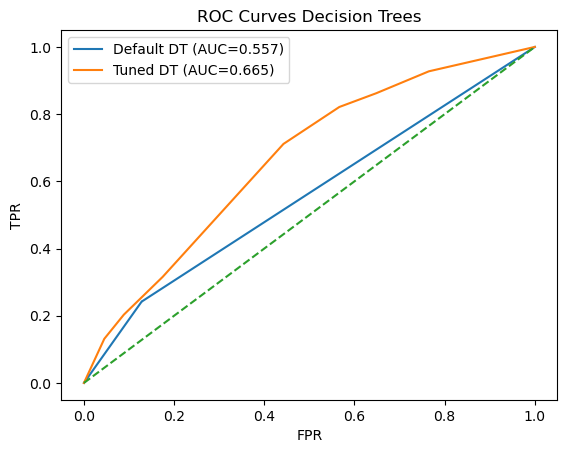

Overfitting gap (Default): 0.20967934175122627
Overfitting gap (Tuned): -4.574562757253542e-05


In [6]:
# Task 2 – Decision Trees
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

RANDOM_STATE = 42

# -------------------------------------------------
# 2.1 Default Decision Tree
# -------------------------------------------------
pipe_dt = Pipeline([
    ("prep", preprocess),  # reuse Task 1 preprocessing
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

pipe_dt.fit(X_train, y_train)

# Predictions
ytr_pred_dt = pipe_dt.predict(X_train)
yte_pred_dt = pipe_dt.predict(X_test)

print("Default DT parameters:", pipe_dt.named_steps["clf"].get_params())
print("Train acc:", accuracy_score(y_train, ytr_pred_dt))
print("Test  acc:", accuracy_score(y_test, yte_pred_dt))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_dt))
print("\nReport:\n", classification_report(y_test, yte_pred_dt))

# Tree size
clf_dt = pipe_dt.named_steps["clf"]
print("Number of nodes:", clf_dt.tree_.node_count)
print("Number of leaves:", clf_dt.get_n_leaves())

# First & second splits
feat_names = pipe_dt.named_steps["prep"].get_feature_names_out()
print("First split feature:", feat_names[clf_dt.tree_.feature[0]])
print("Second split features:", [feat_names[i] for i in clf_dt.tree_.feature[1:3]])

# Top 5 important features
importances = pd.DataFrame({
    "Feature": feat_names,
    "Importance": clf_dt.feature_importances_
}).sort_values("Importance", ascending=False)
print("Top 5 important features:\n", importances.head())

# ROC for default DT
yprob_dt = pipe_dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, yprob_dt)
auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Default DT (AUC={auc_dt:.3f})")


# -------------------------------------------------
# 2.2 Tuned Decision Tree with GridSearchCV
# -------------------------------------------------
pipe_grid = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Hyperparameters: depth, leaf size, split size, criterion
param_grid = {
    "clf__max_depth": [3, 5, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(pipe_grid, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Predictions
ytr_pred_grid = grid_dt.predict(X_train)
yte_pred_grid = grid_dt.predict(X_test)

print("Best params (Tuned DT):", grid_dt.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_grid))
print("Test  acc:", accuracy_score(y_test, yte_pred_grid))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_grid))
print("\nReport:\n", classification_report(y_test, yte_pred_grid))

# Tree size
best_grid = grid_dt.best_estimator_.named_steps["clf"]
print("Number of nodes:", best_grid.tree_.node_count)
print("Number of leaves:", best_grid.get_n_leaves())

# First & second splits
feat_names = grid_dt.best_estimator_.named_steps["prep"].get_feature_names_out()
print("First split feature:", feat_names[best_grid.tree_.feature[0]])
print("Second split features:", [feat_names[i] for i in best_grid.tree_.feature[1:3]])

# Top 5 important features
importances_grid = pd.DataFrame({
    "Feature": feat_names,
    "Importance": best_grid.feature_importances_
}).sort_values("Importance", ascending=False)
print("Top 5 important features:\n", importances_grid.head())

# ROC for tuned DT
yprob_grid = grid_dt.predict_proba(X_test)[:,1]
fpr_grid, tpr_grid, _ = roc_curve(y_test, yprob_grid)
auc_grid = auc(fpr_grid, tpr_grid)
plt.plot(fpr_grid, tpr_grid, label=f"Tuned DT (AUC={auc_grid:.3f})")


# -------------------------------------------------
# 2.3 Comparison ROC
# -------------------------------------------------
plt.plot([0,1],[0,1],"--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curves Decision Trees"); plt.show()

# Overfitting gaps
gap_dt   = accuracy_score(y_train, ytr_pred_dt)   - accuracy_score(y_test, yte_pred_dt)
gap_grid = accuracy_score(y_train, ytr_pred_grid) - accuracy_score(y_test, yte_pred_grid)
print("Overfitting gap (Default):", gap_dt)
print("Overfitting gap (Tuned):", gap_grid)


In [7]:
# -----------------------------
# 2.4 Characteristics of cars most likely to be "kicks"
# -----------------------------

# Pick the better model (Default vs Tuned) by test accuracy
use_tuned = accuracy_score(y_test, yte_pred_grid) >= accuracy_score(y_test, yte_pred_dt)
chosen_dt = grid_dt.best_estimator_.named_steps["clf"] if use_tuned else pipe_dt.named_steps["clf"]
model_name = "Tuned DT" if use_tuned else "Default DT"

print("Better model selected:", model_name)

# Get feature names
feat_names = (grid_dt.best_estimator_.named_steps["prep"].get_feature_names_out() 
              if use_tuned else pipe_dt.named_steps["prep"].get_feature_names_out())

# Top 10 important features
importances = pd.DataFrame({
    "Feature": feat_names,
    "Importance": chosen_dt.feature_importances_
}).sort_values("Importance", ascending=False)

print("\nTop 10 important features used by", model_name)
display(importances.head(10))

# First and second split features
first_split = feat_names[chosen_dt.tree_.feature[0]]
second_splits = [feat_names[i] for i in chosen_dt.tree_.feature[1:3]]

print("First split feature:", first_split)
print("Second split features:", second_splits)


Better model selected: Tuned DT

Top 10 important features used by Tuned DT


,Feature,Importance
1,VehYear,0.409215
2,WheelTypeID,0.209906
13,VehBCost,0.203208
19,Auction_MANHEIM,0.086104
129,WheelType_Covers,0.053880
128,WheelType_Alloy,0.037688
0,PurchaseTimestamp,0.000000
85,Size_SMALL SUV,0.000000
86,Size_SMALL TRUCK,0.000000
87,Size_SPECIALTY,0.000000


First split feature: VehYear
Second split features: ['VehBCost', 'WheelType_Alloy']


In [8]:
# Reuse from Task 1: preprocess, X_train, X_test, y_train, y_test
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Fixed `RANDOM_STATE` for repeatable results.
RANDOM_STATE = 42

In [9]:
# Reusing Task-1 preprocessing in a single end-to-end pipeline
pipe_full = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameter tuning: regularisation type & strength
# L1/L2 regularisations control sparsity vs ridge-style shrinkage
# Liblinear/saga support L1
param_grid_full = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_full = GridSearchCV(pipe_full, param_grid_full, cv=5, scoring="accuracy", n_jobs=-1)
grid_full.fit(X_train, y_train)

# Predictions
ytr_pred_full = grid_full.predict(X_train)
yte_pred_full = grid_full.predict(X_test)

print("Best params:", grid_full.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_full))
print("Test  acc:", accuracy_score(y_test, yte_pred_full))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_full))
print("\nReport:\n", classification_report(y_test, yte_pred_full))

# Top 5 features
best_full = grid_full.best_estimator_
feat_names = best_full.named_steps["prep"].get_feature_names_out()
coefs = best_full.named_steps["clf"].coef_[0]
top5 = pd.DataFrame({"Feature": feat_names, "Coef": coefs, "Abs": np.abs(coefs)}).sort_values("Abs", ascending=False).head(5)
display(top5)

# Using predicted probabilities to compute ROC/AUC
yprob_full = best_full.predict_proba(X_test)[:,1]
fpr_full, tpr_full, _ = roc_curve(y_test, yprob_full)
auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label=f"Full (AUC={auc_full:.3f})")

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Train acc: 0.8707655213984328
Test  acc: 0.8706605593056895

Confusion matrix:
 [[7221    1]
 [1072    2]]

Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.67      0.00      0.00      1074

    accuracy                           0.87      8296
   macro avg       0.77      0.50      0.47      8296
weighted avg       0.84      0.87      0.81      8296



,Feature,Coef,Abs
13,VehBCost,-0.311732,0.311732
1,VehYear,-0.309670,0.309670
8,MMRCurrentAuctionAveragePrice,0.270037,0.270037
11,MMRCurrentRetailCleanPrice,-0.268263,0.268263
129,WheelType_Covers,-0.261478,0.261478


Best params (RFE): {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'rfe__n_features_to_select': 80}
Train acc: 0.8706449668474985
Test  acc: 0.8707810993249759


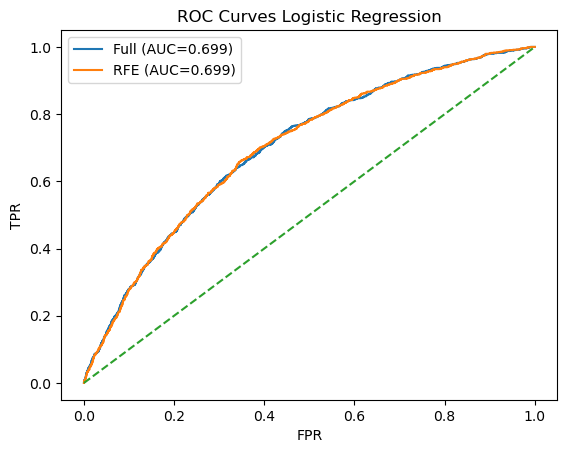

Overfitting gap (Full): 0.00010496209274324375
Overfitting gap (RFE): -0.0001361324774774575


In [10]:
# Base estimator is used by RFE to score feature usefulness
base_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="liblinear", penalty="l2")

pipe_rfe = Pipeline([
    ("prep", preprocess),
    ("rfe", RFE(base_lr, n_features_to_select=50, step=0.1)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameters to tune:
# How many features RFE should keep
# Logistic penalty type & regularisation strength (C)
# Compatible solvers
param_grid_rfe = {
    "rfe__n_features_to_select": [30, 50, 80],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_rfe = GridSearchCV(pipe_rfe, param_grid_rfe, cv=5, scoring="accuracy", n_jobs=-1)
grid_rfe.fit(X_train, y_train)

# Predictions
ytr_pred_rfe = grid_rfe.predict(X_train)
yte_pred_rfe = grid_rfe.predict(X_test)

print("Best params (RFE):", grid_rfe.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_rfe))
print("Test  acc:", accuracy_score(y_test, yte_pred_rfe))

# Plotting the ROC curve
best_rfe = grid_rfe.best_estimator_
yprob_rfe = best_rfe.predict_proba(X_test)[:,1]
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, yprob_rfe)
auc_rfe = auc(fpr_rfe, tpr_rfe)
plt.plot(fpr_rfe, tpr_rfe, label=f"RFE (AUC={auc_rfe:.3f})")

# Plotting the diagonal reference and finalising the ROC figure
plt.plot([0,1],[0,1],"--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves Logistic Regression"); plt.show()

# Checking overfitting (comparing train vs test accuracy gaps)
gap_full = accuracy_score(y_train, ytr_pred_full) - accuracy_score(y_test, yte_pred_full)
gap_rfe  = accuracy_score(y_train, ytr_pred_rfe) - accuracy_score(y_test, yte_pred_rfe)
print("Overfitting gap (Full):", gap_full)
print("Overfitting gap (RFE):", gap_rfe)

In [11]:
# Selecting the better model by test accuracy
# If RFE model tests are atleast as good as the Full model, we will prefer RFE for simplicity
use_rfe = accuracy_score(y_test, yte_pred_rfe) >= accuracy_score(y_test, yte_pred_full)
chosen = best_rfe if use_rfe else best_full
model_name = "RFE" if use_rfe else "Full"

# Getting the post processing feature names, if RFE is better we keep a subset
feat_names_all = chosen.named_steps["prep"].get_feature_names_out()
if "rfe" in chosen.named_steps:
    mask = chosen.named_steps["rfe"].support_
    feat_names = feat_names_all[mask]
else:
    feat_names = feat_names_all

# Coefficients from the final LR
coefs = chosen.named_steps["clf"].coef_.ravel()
print(f"{model_name} features: {len(feat_names)}, coefficients: {len(coefs)}")

coef_df = (pd.DataFrame({"Feature": feat_names, "Coef": coefs})
             .assign(Abs=lambda d: d["Coef"].abs())
             .sort_values("Abs", ascending=False))
top10 = coef_df.head(10)

print("Top contributors from", model_name)
display(top10)

# Positive coef means higher odds of IsBadBuy=1, negative coef means lower odds
print("Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.")
print("Note: one-hot effects are relative to the baseline category.")

RFE features: 80, coefficients: 80
Top contributors from RFE


,Feature,Coef,Abs
78,WheelType_Covers,-0.523426,0.523426
44,PRIMEUNIT_NO,-0.429324,0.429324
14,Auction_MANHEIM,-0.371071,0.371071
12,AUCGUART_GREEN,-0.350971,0.350971
11,VehBCost,-0.347416,0.347416
1,VehYear,-0.330539,0.330539
6,MMRCurrentAuctionAveragePrice,0.271296,0.271296
9,MMRCurrentRetailCleanPrice,-0.267489,0.267489
55,TopThreeAmericanName_GM,-0.262314,0.262314
43,Nationality_AMERICAN,-0.237329,0.237329


Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.
Note: one-hot effects are relative to the baseline category.


## Task 3

In [12]:
# Reuse from Task 1: preprocess, X_train, X_test, y_train, y_test
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Fixed `RANDOM_STATE` for repeatable results.
RANDOM_STATE = 42

In [13]:
# Reusing Task-1 preprocessing in a single end-to-end pipeline
pipe_full = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameter tuning: regularisation type & strength
# L1/L2 regularisations control sparsity vs ridge-style shrinkage
# Liblinear/saga support L1
param_grid_full = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_full = GridSearchCV(pipe_full, param_grid_full, cv=5, scoring="accuracy", n_jobs=-1)
grid_full.fit(X_train, y_train)

# Predictions
ytr_pred_full = grid_full.predict(X_train)
yte_pred_full = grid_full.predict(X_test)

print("Best params:", grid_full.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_full))
print("Test  acc:", accuracy_score(y_test, yte_pred_full))
print("\nConfusion matrix:\n", confusion_matrix(y_test, yte_pred_full))
print("\nReport:\n", classification_report(y_test, yte_pred_full))

# Top 5 features
best_full = grid_full.best_estimator_
feat_names = best_full.named_steps["prep"].get_feature_names_out()
coefs = best_full.named_steps["clf"].coef_[0]
top5 = pd.DataFrame({"Feature": feat_names, "Coef": coefs, "Abs": np.abs(coefs)}).sort_values("Abs", ascending=False).head(5)
display(top5)

# Using predicted probabilities to compute ROC/AUC
yprob_full = best_full.predict_proba(X_test)[:,1]
fpr_full, tpr_full, _ = roc_curve(y_test, yprob_full)
auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label=f"Full (AUC={auc_full:.3f})")

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Train acc: 0.8707655213984328
Test  acc: 0.8706605593056895

Confusion matrix:
 [[7221    1]
 [1072    2]]

Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.67      0.00      0.00      1074

    accuracy                           0.87      8296
   macro avg       0.77      0.50      0.47      8296
weighted avg       0.84      0.87      0.81      8296



,Feature,Coef,Abs
13,VehBCost,-0.311732,0.311732
1,VehYear,-0.309670,0.309670
8,MMRCurrentAuctionAveragePrice,0.270037,0.270037
11,MMRCurrentRetailCleanPrice,-0.268263,0.268263
129,WheelType_Covers,-0.261478,0.261478


Best params (RFE): {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'rfe__n_features_to_select': 80}
Train acc: 0.8706449668474985
Test  acc: 0.8707810993249759


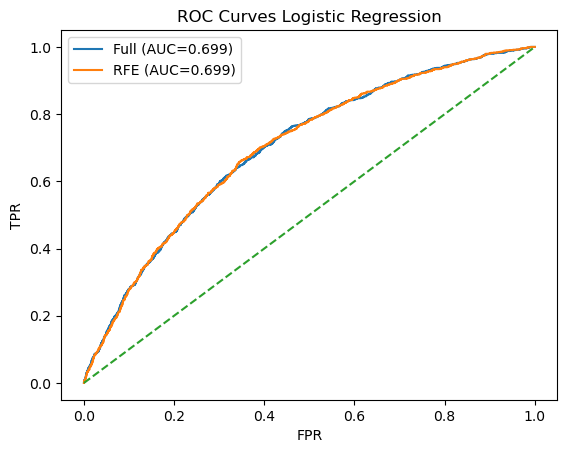

Overfitting gap (Full): 0.00010496209274324375
Overfitting gap (RFE): -0.0001361324774774575


In [14]:
# Base estimator is used by RFE to score feature usefulness
base_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="liblinear", penalty="l2")

pipe_rfe = Pipeline([
    ("prep", preprocess),
    ("rfe", RFE(base_lr, n_features_to_select=50, step=0.1)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Hyperparameters to tune:
# How many features RFE should keep
# Logistic penalty type & regularisation strength (C)
# Compatible solvers
param_grid_rfe = {
    "rfe__n_features_to_select": [30, 50, 80],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"],
}

# 5-fold CV tuned for accuracy
grid_rfe = GridSearchCV(pipe_rfe, param_grid_rfe, cv=5, scoring="accuracy", n_jobs=-1)
grid_rfe.fit(X_train, y_train)

# Predictions
ytr_pred_rfe = grid_rfe.predict(X_train)
yte_pred_rfe = grid_rfe.predict(X_test)

print("Best params (RFE):", grid_rfe.best_params_)
print("Train acc:", accuracy_score(y_train, ytr_pred_rfe))
print("Test  acc:", accuracy_score(y_test, yte_pred_rfe))

# Plotting the ROC curve
best_rfe = grid_rfe.best_estimator_
yprob_rfe = best_rfe.predict_proba(X_test)[:,1]
fpr_rfe, tpr_rfe, _ = roc_curve(y_test, yprob_rfe)
auc_rfe = auc(fpr_rfe, tpr_rfe)
plt.plot(fpr_rfe, tpr_rfe, label=f"RFE (AUC={auc_rfe:.3f})")

# Plotting the diagonal reference and finalising the ROC figure
plt.plot([0,1],[0,1],"--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves Logistic Regression"); plt.show()

# Checking overfitting (comparing train vs test accuracy gaps)
gap_full = accuracy_score(y_train, ytr_pred_full) - accuracy_score(y_test, yte_pred_full)
gap_rfe  = accuracy_score(y_train, ytr_pred_rfe) - accuracy_score(y_test, yte_pred_rfe)
print("Overfitting gap (Full):", gap_full)
print("Overfitting gap (RFE):", gap_rfe)

In [15]:
# Selecting the better model by test accuracy
# If RFE model tests are atleast as good as the Full model, we will prefer RFE for simplicity
use_rfe = accuracy_score(y_test, yte_pred_rfe) >= accuracy_score(y_test, yte_pred_full)
chosen = best_rfe if use_rfe else best_full
model_name = "RFE" if use_rfe else "Full"

# Getting the post processing feature names, if RFE is better we keep a subset
feat_names_all = chosen.named_steps["prep"].get_feature_names_out()
if "rfe" in chosen.named_steps:
    mask = chosen.named_steps["rfe"].support_
    feat_names = feat_names_all[mask]
else:
    feat_names = feat_names_all

# Coefficients from the final LR
coefs = chosen.named_steps["clf"].coef_.ravel()
print(f"{model_name} features: {len(feat_names)}, coefficients: {len(coefs)}")

coef_df = (pd.DataFrame({"Feature": feat_names, "Coef": coefs})
             .assign(Abs=lambda d: d["Coef"].abs())
             .sort_values("Abs", ascending=False))
top10 = coef_df.head(10)

print("Top contributors from", model_name)
display(top10)

# Positive coef means higher odds of IsBadBuy=1, negative coef means lower odds
print("Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.")
print("Note: one-hot effects are relative to the baseline category.")

RFE features: 80, coefficients: 80
Top contributors from RFE


,Feature,Coef,Abs
78,WheelType_Covers,-0.523426,0.523426
44,PRIMEUNIT_NO,-0.429324,0.429324
14,Auction_MANHEIM,-0.371071,0.371071
12,AUCGUART_GREEN,-0.350971,0.350971
11,VehBCost,-0.347416,0.347416
1,VehYear,-0.330539,0.330539
6,MMRCurrentAuctionAveragePrice,0.271296,0.271296
9,MMRCurrentRetailCleanPrice,-0.267489,0.267489
55,TopThreeAmericanName_GM,-0.262314,0.262314
43,Nationality_AMERICAN,-0.237329,0.237329


Positive coef -> higher odds of IsBadBuy=1 (likely kick); Negative -> lower odds.
Note: one-hot effects are relative to the baseline category.


## Task 4

In [16]:
# === Task 4 BOOTSTRAP ===
# Fix mixed-type categorical issues and avoid running OneHot inside the DT grid.

import os, glob, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Defaults
if "RANDOM_STATE" not in globals(): RANDOM_STATE = 42
if "TARGET_COL"   not in globals(): TARGET_COL   = "IsBadBuy"

# 1) Load df if missing
def _find_csv():
    for p in ["data/kick.csv", "kick.csv", "assignment 1 data kick.csv"]:
        if os.path.isfile(p): return p
    for p in glob.glob("**/*.csv", recursive=True):
        if "kick" in os.path.basename(p).lower(): return p
    return None

if "df" not in globals():
    path = _find_csv()
    if not path:
        raise FileNotFoundError("kick.csv not found. Put it in ./data/ or next to the notebook.")
    # Avoid dtype fragmentation warnings
    df = pd.read_csv(path, low_memory=False)
    # Turn '?' into NaN
    df.replace("?", np.nan, inplace=True)
    # Promote numeric-like object columns to numeric (simple heuristic)
    for c in df.columns:
        if c == TARGET_COL:
            continue
        if df[c].dtype == "object":
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().mean() > 0.6:  # majority numeric -> treat as numeric
                df[c] = s

# 2) Train/test split if missing
if not all(v in globals() for v in ["X_train","X_test","y_train","y_test"]):
    drop_cols = [c for c in ["PurchaseID","PurchaseDate"] if c in df.columns]
    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL] + drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

# 3) Preprocess pipeline (categorical forced to string AFTER impute)
if "preprocess" not in globals():
    num_feat = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_feat = X_train.columns.difference(num_feat).tolist()

    numeric = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("to_str", FunctionTransformer(lambda X: X.astype(object).astype(str))),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocess = ColumnTransformer(
        [("num", numeric, num_feat),
         ("cat", categorical, cat_feat)],
        remainder="drop",
        verbose_feature_names_out=False
    )

# 4) Fit preprocess ONCE and grid-search DT on the preprocessed matrix (no OneHot inside the grid)
if "dt_best" not in globals():
    # Fit preprocessor on train and transform to numeric matrix
    prep_fitted = preprocess.fit(X_train, y_train)
    Xtr = prep_fitted.transform(X_train)
    # Ensure dense
    if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()

    # Now search a Decision Tree directly on Xtr (pure numeric) -> avoids mixed-type encoder issues
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
    grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 10, 50],
        "min_samples_leaf": [1, 5, 25],
    }
    dt_search = GridSearchCV(dt, grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    dt_search.fit(Xtr, y_train)
    best_dt = dt_search.best_estimator_

    # Rebuild a Pipeline so that downstream code can use dt_best.named_steps["prep"]/["clf"]
    dt_best = Pipeline([("prep", prep_fitted), ("clf", best_dt)])
    print("[Task4 bootstrap] Fitted preprocess and tuned DecisionTree on preprocessed matrix.")
else:
    print("[Task4 bootstrap] Using existing dt_best / preprocess / split.")


[Task4 bootstrap] Fitted preprocess and tuned DecisionTree on preprocessed matrix.


**Task 4.1 — Additional processing for NN**

- Numeric features are **standardized** (zero-mean / unit-variance) via `StandardScaler`.
- Categorical features are **one-hot encoded** with `OneHotEncoder(handle_unknown="ignore")`.
- Missing values are handled by `SimpleImputer` (median for numeric, most_frequent for categorical).
- These steps are already defined in our `preprocess` from Task 1 and applied *consistently* to train/test to avoid leakage.
- Standardization is **important for NN** to stabilize gradients and speed up convergence.


NN baseline (full) | Train=0.873 Test=0.871 AUC=0.708
NN tuned (full) | Train=0.880 Test=0.870 AUC=0.700


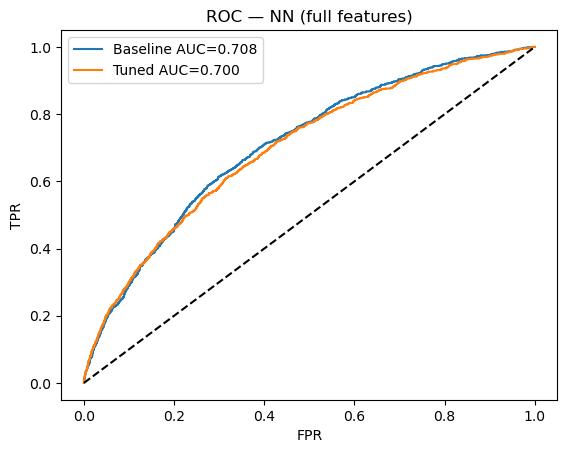

NN baseline (reduced) | Train=0.871 Test=0.870 AUC=0.702
NN tuned (reduced) | Train=0.871 Test=0.868 AUC=0.704


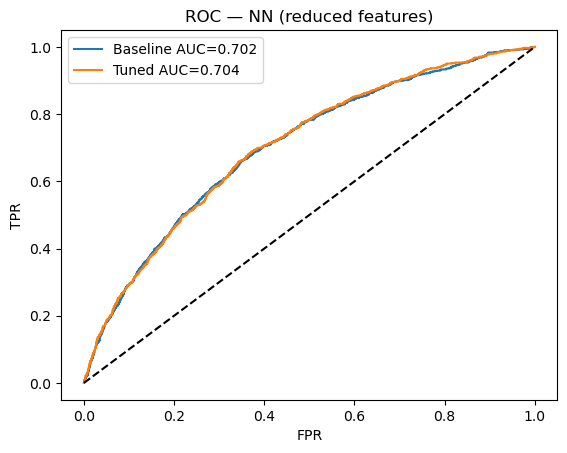

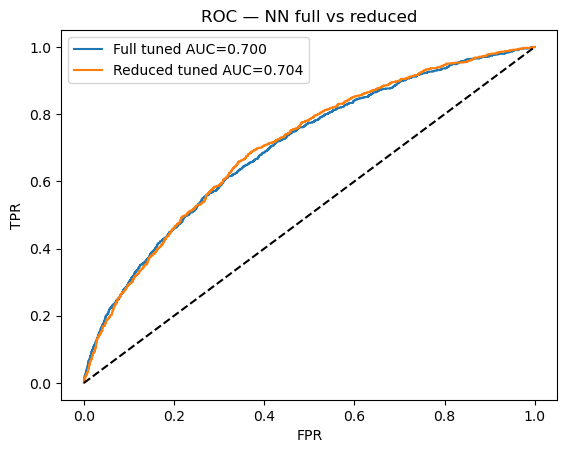

In [17]:
# === Task 4. Predictive Modeling Using Neural Networks ===

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- Set data for NN ---
prep_for_nn = preprocess.fit(X_train, y_train)
Xtr = prep_for_nn.transform(X_train)
Xte = prep_for_nn.transform(X_test)
if hasattr(Xtr, "toarray"): Xtr = Xtr.toarray()
if hasattr(Xte, "toarray"): Xte = Xte.toarray()

# helper: print acc + AUC
def eval_nn(model, Xtr, ytr, Xte, yte, title="NN"):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    acc_tr = accuracy_score(ytr, yhat_tr)
    acc_te = accuracy_score(yte, yhat_te)
    proba_te = model.predict_proba(Xte)[:,1]
    auc_te = roc_auc_score(yte, proba_te)
    print(f"{title} | Train={acc_tr:.3f} Test={acc_te:.3f} AUC={auc_te:.3f}")
    return acc_tr, acc_te, auc_te, proba_te

# --- 4.2 NN Full Features ---
nn_base = MLPClassifier(hidden_layer_sizes=(64,), activation="relu",
                        max_iter=300, early_stopping=True, random_state=RANDOM_STATE)
nn_base.fit(Xtr, y_train)
_,_,auc_b,proba_b = eval_nn(nn_base, Xtr, y_train, Xte, y_test, "NN baseline (full)")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (64,32)],
    "activation": ["relu","tanh"],
    "alpha": [1e-4, 1e-3]
}
nn_gs = GridSearchCV(MLPClassifier(max_iter=300, early_stopping=True, random_state=RANDOM_STATE),
                     param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
nn_gs.fit(Xtr, y_train)
nn_full = nn_gs.best_estimator_
_,_,auc_f,proba_f = eval_nn(nn_full, Xtr, y_train, Xte, y_test, "NN tuned (full)")

# ROC: full features
fpr_b,tpr_b,_ = roc_curve(y_test, proba_b)
fpr_f,tpr_f,_ = roc_curve(y_test, proba_f)
plt.figure()
plt.plot(fpr_b,tpr_b,label=f"Baseline AUC={auc_b:.3f}")
plt.plot(fpr_f,tpr_f,label=f"Tuned AUC={auc_f:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC — NN (full features)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()

# --- 4.3 NN Reduced Features ---
# select top 20 features from DT
dt_model = dt_best.named_steps["clf"]
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.columns.difference(num_cols).tolist()
feat_names = np.array(list(num_cols) + list(ohe.get_feature_names_out(cat_cols)))
top_idx = np.argsort(dt_model.feature_importances_)[::-1][:20]

Xtr_red = Xtr[:, top_idx]
Xte_red = Xte[:, top_idx]

# Baseline reduced NN
nn_red_base = MLPClassifier(hidden_layer_sizes=(64,), activation="relu",
                            max_iter=300, early_stopping=True, random_state=RANDOM_STATE)
nn_red_base.fit(Xtr_red, y_train)
_,_,auc_rb,proba_rb = eval_nn(nn_red_base, Xtr_red, y_train, Xte_red, y_test, "NN baseline (reduced)")

# Tuned reduced NN
param_grid_red = {
    "hidden_layer_sizes": [(64,), (64,32)],
    "activation": ["relu","tanh"],
    "alpha": [1e-4, 1e-3]
}
nn_red_gs = GridSearchCV(MLPClassifier(max_iter=300, early_stopping=True, random_state=RANDOM_STATE),
                         param_grid=param_grid_red, scoring="roc_auc", cv=cv, n_jobs=-1)
nn_red_gs.fit(Xtr_red, y_train)
nn_red = nn_red_gs.best_estimator_
_,_,auc_rt,proba_rt = eval_nn(nn_red, Xtr_red, y_train, Xte_red, y_test, "NN tuned (reduced)")

# ROC: reduced features
fpr_rb,tpr_rb,_ = roc_curve(y_test, proba_rb)
fpr_rt,tpr_rt,_ = roc_curve(y_test, proba_rt)
plt.figure()
plt.plot(fpr_rb,tpr_rb,label=f"Baseline AUC={auc_rb:.3f}")
plt.plot(fpr_rt,tpr_rt,label=f"Tuned AUC={auc_rt:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC — NN (reduced features)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()

# --- 4.4 Compare Full vs Reduced (best models) ---
plt.figure()
plt.plot(fpr_f,tpr_f,label=f"Full tuned AUC={auc_f:.3f}")
plt.plot(fpr_rt,tpr_rt,label=f"Reduced tuned AUC={auc_rt:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC — NN full vs reduced")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()
